# Obtain the wind effect on the ROMS-SODA output for the tide gauges along the Dutch coast

The ROMS-SODA wind effect is compared to the SODA wind effect, which has already been obtained for a different project.

In [92]:
import xarray as xr
import pandas as pd
import numpy as np
import copy

from sklearn.linear_model import LinearRegression as linr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


path = '/Users/iriskeizer/Documents/ROMS/data/wind effect'
path_fig = '/Users/iriskeizer/Documents/ROMS/figures/GLORYS/wind effect'

## Import data

In [93]:
# Import ROMS-GLORYS annual results
roms = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output/GLORYS/spinup2/NorthSea4_avg_spinup2_annual.nc')

In [94]:
# Import GLORYS reanalysis data
glorys = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/GLORYS12V1/processed/glorys.nc')

In [95]:
# Import ERA5 and ERA-interim wind data
path = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data'
era5 = xr.open_mfdataset(f'{path}/era5/raw/*.nc')
eraint = xr.open_mfdataset(f'{path}/era interim/raw/*.nc')

## Data preparation

### Obtain dataset with time, latitude, longitude coordinates

In [96]:
def roms_to_latlon(data):
    '''
    Function to obtain a new dataset for the roms data where dimensions are latitude and longitude 
    data should be the ROMS output dataset 
    '''
    
    data_vars = dict(zeta=(["time", "latitude", "longitude"], data.zeta.values),)
        
    coords = dict(time=(["time"], data.time.values),
             latitude=(["latitude"], data.lat_rho.values[:,0]),
             longitude=(["longitude"], data.lon_rho.values[0]))
    
    return xr.Dataset(data_vars = data_vars, coords = coords)


roms = roms_to_latlon(roms)

In [97]:
# Obtain annual averages
glorys = glorys.groupby('time.year').mean().rename({'year':'time'})


In [98]:
# Drop unnecessary variables
glorys = glorys.drop(['so', 'thetao', 'uo', 'vo', 'depth'])

### ERA preparation

In [99]:
# Remove data before 1993 and after 2020
era5 = era5.where((era5.time.dt.year < 2021) & (era5.time.dt.year > 2017), drop = True)
eraint = eraint.where((eraint.time.dt.year > 1992) & (eraint.time.dt.year < 2018), drop = True)

In [100]:
# Obtain annual averages
era5 = era5.groupby('time.year').mean('time').rename({'year' : 'time'})
eraint = eraint.groupby('time.year').mean('time').rename({'year' : 'time'})

In [101]:
# Obtain wind stress
era5 = era5.assign(u2 = era5.u10*(np.sqrt(era5.u10**2+era5.v10**2)), v2 = era5.v10*(np.sqrt(era5.u10**2+era5.v10**2)))
eraint = eraint.assign(u2 = eraint.u10*(np.sqrt(eraint.u10**2+eraint.v10**2)), v2 = eraint.v10*(np.sqrt(eraint.u10**2+eraint.v10**2)))

In [102]:
# Drop expver
era5 = era5.sel(expver=1).drop(['expver'])

In [103]:
# Drop wind speed
era5 = era5.drop(['u10', 'v10'])
eraint = eraint.drop(['u10', 'v10'])

In [104]:
# Combine data sets
windstress = xr.merge([era5, eraint])

In [105]:
# Sort coordinates
windstress = windstress.sortby(['time', 'latitude', 'longitude'])

### Select data near tide gauge stations

In [106]:
stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'Average']


def station_coords(): 
    """
    Function to obtain the coordinates of the tide gauge stations as a dataframe
    
    """
    
    
    # Necessary declarations to obtain tide gauge station coordinates
    path_locations = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/rlr_annual/filelist.txt'
    loc_num = [20, 22, 23, 24, 25, 32]
    col_names = ['id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality']
    
    # Create dataframe
    df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
    df = df.set_index('id')
    df = df.loc[loc_num, :]
    df['name'] = stations[:-1]
    df = df.set_index('name')
    df = df.drop(['coastline_code', 'station_code', 'quality'], axis=1)
    
    return df


coord_df = station_coords()

#### Select tide gauge data for roms output

In [107]:
roms_tg = pd.DataFrame({'time' : roms.time.data}).set_index('time')

for station in coord_df.index:
    
    # Select data near tide gauge
    if station in ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Harlingen']:
        data_stat = roms.sel(longitude = coord_df['lon'][station]-0.3, latitude = coord_df['lat'][station], method = 'Nearest').zeta.data
    elif station == 'Delfzijl':
        data_stat = roms.sel(longitude = coord_df['lon'][station], latitude = coord_df['lat'][station]+0.3, method = 'Nearest').zeta.data
    else:
        data_stat = roms.sel(longitude = coord_df['lon'][station], latitude = coord_df['lat'][station], method = 'Nearest').zeta.data
    
        
    # Obtain anomaly
    data_stat_anom = data_stat - data_stat[0] 
    
    # Save in dataframe
    roms_tg[station] = data_stat_anom
    
roms_tg['Average'] = roms_tg.mean(axis=1)

#### Select tide gauge data for windstress

In [108]:
windstress_tg = pd.DataFrame({'time' : windstress.time.data}).set_index('time')
lst_u2 = []
lst_v2 = []

for station in coord_df.index:
    
    windstress_tg[station, '$U \sqrt{u^2+v^2}$'] = windstress.sel(longitude = coord_df['lon'][station], latitude = coord_df['lat'][station], 
                                                      method = 'Nearest').u2.data
    windstress_tg[station, '$V \sqrt{u^2+v^2}$'] = windstress.sel(longitude = coord_df['lon'][station], latitude = coord_df['lat'][station], 
                                                      method = 'Nearest').v2.data
    lst_u2.append([station, '$U \sqrt{u^2+v^2}$'])
    lst_v2.append([station, '$V \sqrt{u^2+v^2}$'])

windstress_tg['Average', '$U \sqrt{u^2+v^2}$'] = windstress_tg[lst_u2].mean(axis=1)
windstress_tg['Average', '$V \sqrt{u^2+v^2}$'] = windstress_tg[lst_v2].mean(axis=1)

lst_u2 = lst_u2+[['Average', '$U \sqrt{u^2+v^2}$']]
lst_v2 = lst_v2+[['Average', '$V \sqrt{u^2+v^2}$']]


#### Select tide gauge data for glorys

In [109]:
glorys_tg = pd.DataFrame({'time' : glorys.time.data}).set_index('time')

for station in coord_df.index:
    
    # Select data near tide gauge
    if station == 'Delfzijl':
        data_stat = glorys.sel(longitude = coord_df['lon'][station], latitude = coord_df['lat'][station] + 0.1, method = 'Nearest').zos.data
    else:
        data_stat = glorys.sel(longitude = coord_df['lon'][station], latitude = coord_df['lat'][station], method = 'Nearest').zos.data
        
    # Obtain anomaly
    data_stat_anom = data_stat - data_stat[0] 
    
    # Save in dataframe
    glorys_tg[station] = data_stat_anom
    
glorys_tg['Average'] = glorys_tg.mean(axis=1)


<AxesSubplot:xlabel='time'>

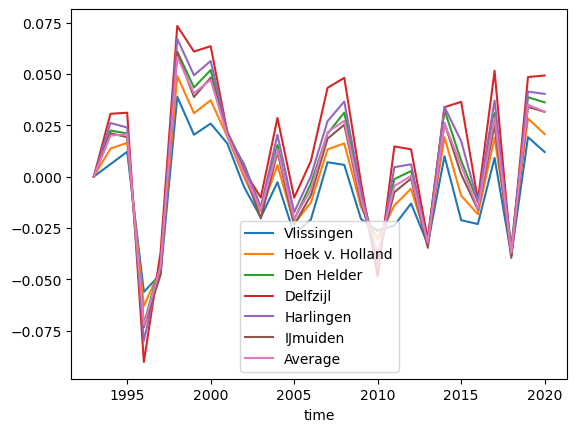

In [110]:
roms_tg.plot()

<AxesSubplot:xlabel='time'>

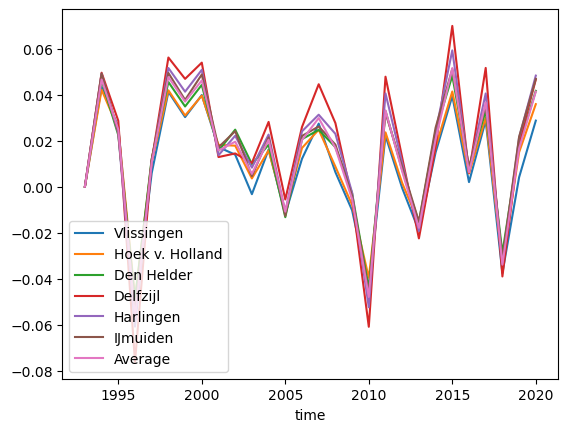

In [111]:
glorys_tg.plot()

<AxesSubplot:xlabel='time'>

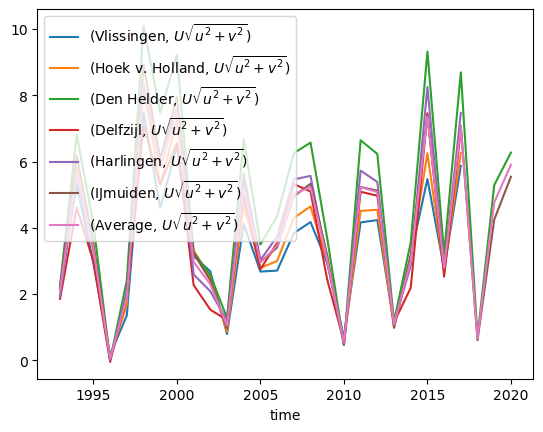

In [112]:
windstress_tg[lst_u2].plot()

<AxesSubplot:xlabel='time'>

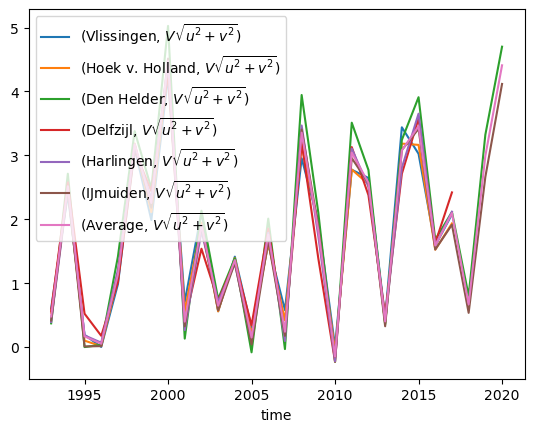

In [113]:
windstress_tg[lst_v2].plot()

In [114]:
glorys_tg.to_csv('/Users/iriskeizer/Documents/ROMS/data/tg_ocdyn/glorys_tg_ocdyn.csv')
roms_tg.to_csv('/Users/iriskeizer/Documents/ROMS/data/tg_ocdyn/roms_glorys_tg_ocdyn.csv')

## Perform regression

In [117]:
stations = roms_tg.columns

path = '/Users/iriskeizer/Documents/ROMS/data/wind effect'


def regression(sea_data, wind_data):
    """
    Function to perform the regression with sea-level and wind-stress data to obtain the wind effect on 
    sea level along the Dutch coast.
    
    """
    
    # Obtain trend timeseries to add to dataframe later
    trend = wind_data.index - wind_data.index[0]
    
    
    
    # Create lists containing names of regression terms
    regg_names = ['$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$', 'trend']
    wind_names = ['$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$']
    
    
    # Create lists to save datasets
    timeseries_lst = []
    netcdf_lst = []
    reg_results_lst = []
    coef_lst = []
    intercept_lst = []
    rmse_lst = []
    R2_total_lst = []
    R2_wind_lst = []
    R2_u2_lst = []
    R2_v2_lst = []
    
    # Perform regression for each station
    for station in stations:
        
        # Create dataframe for y 
        y = sea_data[station]
    
        # Create dataframe for x
        x = pd.DataFrame(data={'time': wind_data.index,
                              '$U \sqrt{u^2+v^2}$': wind_data[station, '$U \sqrt{u^2+v^2}$'],
                              '$V \sqrt{u^2+v^2}$': wind_data[station, '$V \sqrt{u^2+v^2}$'],
                              'trend': trend,})
        
        x = x.set_index('time')
        
        # Define regression
        regression_ = linr()
        
        
        # Interpolate to remove nan values
        x = x.interpolate(axis=0)
        y = y.interpolate(axis=0)
        
        
        # Standardize x
        scaler = StandardScaler()
        x = copy.deepcopy(x)
        x.iloc[:,:] = scaler.fit_transform(x)
        
        
        # Create copy such that regression result can be obtained for full timeseries
        x_timeseries = copy.deepcopy(x)
        
        
        # Create dataframes of equal time span
        y = y[y.index.isin(x.index)]
        x = x[x.index.isin(y.index)]
        
        
        # Fit the regression model and add results to lists
        fit = regression_.fit(x,y)
        score = regression_.score(x,y) # R^2 for the whole regression including the trend 
        intercept_lst.append(regression_.intercept_)
        coef_lst.append(regression_.coef_.tolist())
        
        
        # Calculate rmse
        yhat = regression_.predict(x)
        mse = mean_squared_error(y, yhat) # Calculate insample mse
        rmse_lst.append(np.sqrt(mse))
        
        
        # Obtain dataframe containing timeseries resulting from regression
        df = pd.DataFrame(data=dict(time=x_timeseries.index))
        df = df.set_index('time')
        
        for i in range(len(regg_names)):
            df[regg_names[i]] = coef_lst[-1][i] * x_timeseries[x_timeseries.columns[i]]
            
        df['total'] = df.sum(axis=1)
        df['wind total'] = df[wind_names].sum(axis=1)
        
        # Add dataframe to list 
        timeseries_lst.append(df)
        
        netcdf_lst.append(xr.Dataset(data_vars=dict(u2=(['time'],  df['$U \sqrt{u^2+v^2}$'].values),
                                                    v2=(['time'],  df['$V \sqrt{u^2+v^2}$'].values),
                                                    trend=(['time'],  df['trend'].values),
                                                    total=(['time'],  df['total'].values),
                                                    wind_total=(['time'],  df['wind total'].values),
                                                    time = df.index.values)))
        
        # Calculate R^2 values
        R2_total_lst.append(score) # R^2 for the whole regression including the trend
        R2_wind_lst.append(R2_var(df, y, 'wind total', regression_))
        R2_u2_lst.append(R2_var(df, y, '$U \sqrt{u^2+v^2}$', regression_))
        R2_v2_lst.append(R2_var(df, y, '$V \sqrt{u^2+v^2}$', regression_))
                

            
    # Create dataframe of timeseries
    timeseries_df = pd.concat(timeseries_lst, axis=1, keys = stations)      
    timeseries_nc = xr.concat(netcdf_lst, dim=stations).rename({"concat_dim":"station"})       
    
    # Save netcdf file
    timeseries_nc.to_netcdf(f'{path}/timeseries_glorys.nc')
    
    
    
    # Create dataframe of coefficients
    
    # Transpose coef list
    numpy_array = np.array(coef_lst)
    transpose = numpy_array.T
    coef_lst_T = transpose.tolist()
    
    results_df = pd.DataFrame(data={'station': stations, 
                                    'R$^2$' : R2_total_lst,
                                    'R$^2_{wind}$' : R2_wind_lst,
                                    'R$^2_{U \sqrt{u^2+v^2}}$' : R2_u2_lst,
                                    'R$^2_{V \sqrt{u^2+v^2}}$' : R2_v2_lst,
                                    'RMSE': rmse_lst, 
                                    'constant' : intercept_lst})
    
    
    
    for i in range(len(coef_lst_T)):
        results_df[regg_names[i]] = coef_lst_T[i]
        
    results_df = results_df.set_index('station')
     
        
    results_nc = xr.Dataset(data_vars=dict(r2=(['station'], R2_total_lst),
                                                        r2_wind=(['station'], R2_wind_lst),
                                                        r2_u2=(['station'], R2_u2_lst),
                                                        r2_v2=(['station'], R2_v2_lst),
                                                        rmse=(['station'], rmse_lst),
                                                        constant=(['station'], intercept_lst),
                                                        u2=(['station'], coef_lst_T[0]),
                                                        v2=(['station'], coef_lst_T[1]),
                                                        trend=(['station'], coef_lst_T[2]),
                                                        station = stations))
    
    
    # Save netcdf file
    results_nc.to_netcdf(f'{path}/results_glorys.nc')
    
    
    return(results_nc, timeseries_nc)


    
    
def R2_var(df, y, var, regression_):
    """
    Function to obtain R-squared for a specific variable
    
    For var choose  ['wind total', '$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$']
    """
    
    x = pd.DataFrame(data={'time': df.index.values, 
                                var : df[var].values})
    x = x.set_index('time')
    x = x[x.index.isin(y.index)]
    
    fit = regression_.fit(x, y)
    score = regression_.score(x,y)
    
    return score


In [118]:
results_glorys, timeseries_glorys = regression(glorys_tg, windstress_tg)

In [119]:
results_roms, timeseries_roms = regression(roms_tg, windstress_tg)

## Plot wind effect

In [120]:
timeseries_glorys

<xarray.Dataset>
Dimensions:     (station: 7, time: 28)
Coordinates:
  * time        (time) int64 1993 1994 1995 1996 1997 ... 2017 2018 2019 2020
  * station     (station) object 'Vlissingen' 'Hoek v. Holland' ... 'Average'
Data variables:
    u2          (station, time) float64 -0.01088 0.01239 ... 0.007625 0.01775
    v2          (station, time) float64 -0.00538 0.003325 ... 0.004558 0.009916
    trend       (station, time) float64 0.0143 0.01324 ... -0.006607 -0.007135
    total       (station, time) float64 -0.001962 0.02896 ... 0.005576 0.02053
    wind_total  (station, time) float64 -0.01626 0.01572 ... 0.01218 0.02767

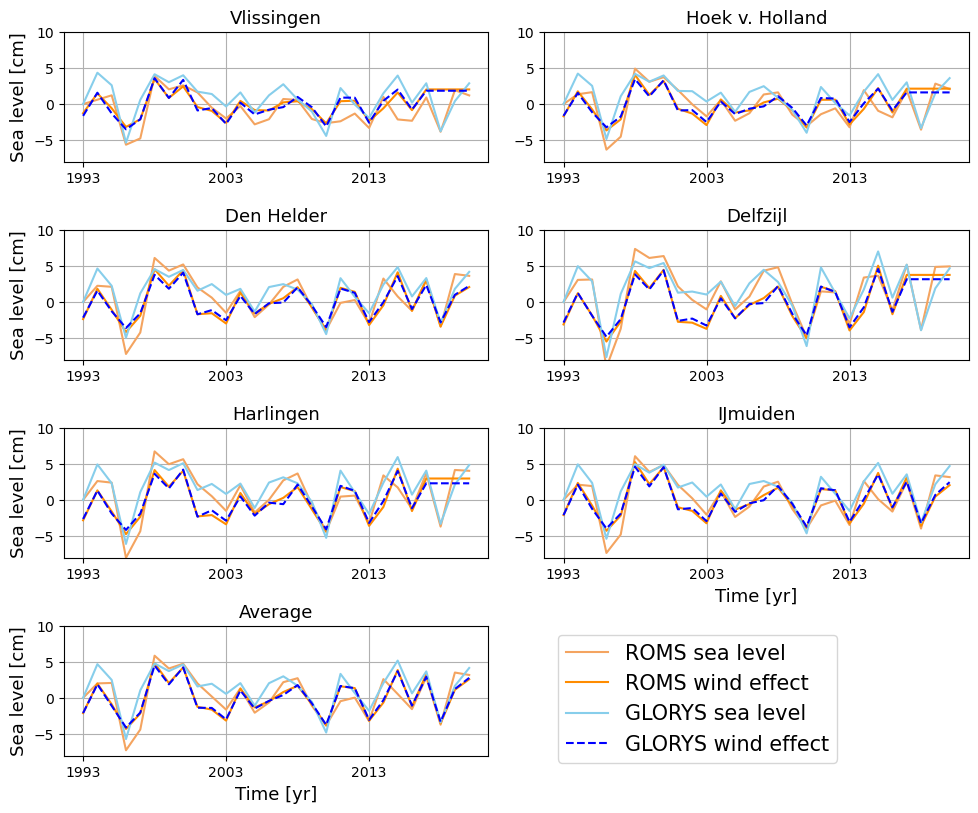

In [121]:
fig, axs = plt.subplots(4, 2, figsize=(10, 8))


for i in range(4):


    ax = axs[i,0]
    ax.plot(roms_tg.index.values, roms_tg[stations[2*i]].values*100, color='sandybrown')
    ax.plot(timeseries_roms.time.data, timeseries_roms.sel(station=stations[2*i]).wind_total.data*100, color='darkorange')
    ax.plot(glorys_tg.index.values, glorys_tg[stations[2*i]].values*100, color='skyblue')
    ax.plot(timeseries_glorys.time.data, timeseries_glorys.sel(station=stations[2*i]).wind_total.data*100, color='blue', linestyle = '--')
    ax.set_title(stations[2*i], fontsize = 13)
    ax.set_xlabel('')
    ax.set_ylabel('Sea level [cm]', fontsize = 13)
    ax.set_ylim(-8, 10)
    ax.set_xticks(range(1993, 2021, 10))
    plt.tight_layout()
    ax.grid()

    ax = axs[i,1]
    if i == 3:
        fig.delaxes(axs[3,1])
    else:

        ax.plot(roms_tg.index.values, roms_tg[stations[2*i+1]].values*100, color='sandybrown')
        ax.plot(timeseries_roms.time.data, timeseries_roms.sel(station=stations[2*i+1]).wind_total.data*100, color='darkorange')
        ax.plot(glorys_tg.index.values, glorys_tg[stations[2*i+1]].values*100, color='skyblue')
        ax.plot(timeseries_glorys.time.data, timeseries_glorys.sel(station=stations[2*i+1]).wind_total.data*100, color='blue', linestyle = '--')
        ax.set_title(stations[2*i+1], fontsize = 13)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_ylim(-8, 10)
        ax.set_xticks(range(1993, 2021, 10))
        plt.tight_layout()
        ax.grid()
        
        
    axs[3,0].set_xlabel('Time [yr]', fontsize = 13)
    axs[2,1].set_xlabel('Time [yr]', fontsize = 13)
    
labels=['ROMS sea level','ROMS wind effect', 'GLORYS sea level','GLORYS wind effect']
fig.legend(labels=labels, loc=(0.57, 0.062), fontsize = 15)
    

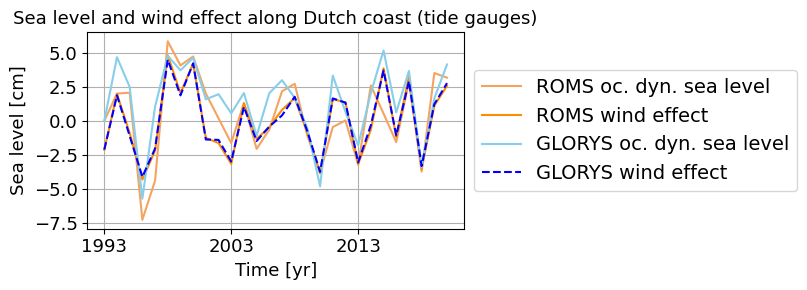

In [122]:
plt.figure(figsize = (8,3))
     
plt.plot(roms_tg.index.values, roms_tg['Average'].values*100, color='sandybrown')
plt.plot(timeseries_roms.time.data, timeseries_roms.sel(station='Average').wind_total.data*100, color='darkorange')
plt.plot(glorys_tg.index.values, glorys_tg['Average'].values*100, color='skyblue')
plt.plot(timeseries_glorys.time.data, timeseries_glorys.sel(station='Average').wind_total.data*100, color='blue', linestyle='--')
       
    
plt.xlabel('Time [yr]', fontsize = 13)
plt.ylabel('Sea level [cm]', fontsize = 13)
plt.title(f'Sea level and wind effect along Dutch coast (tide gauges)', fontsize = 13)
plt.xticks(range(1993, 2021, 10), fontsize = 13)
plt.yticks(fontsize = 13)
plt.grid()

labels=['ROMS oc. dyn. sea level','ROMS wind effect', 'GLORYS oc. dyn. sea level','GLORYS wind effect']
plt.legend(labels = labels, fontsize = 14, loc='center left', bbox_to_anchor=(1.0, 0.5))
    
plt.tight_layout()
    
plt.savefig(f'{path_fig}/sealevel_windeffect_dutchcoast_tg', bbox_inches="tight")

The SODA and ROMS wind effect is very similar

## Save data similar as for polygon notebook

In [ ]:
results_df = pd.DataFrame(data={'Coefficient': ['R$^2$', 'R$^2_{wind}$', 'R$^2_{U \sqrt{u^2+v^2}}$', 'R$^2_{V \sqrt{u^2+v^2}}$', 'RMSE', 'constant', 'coef$_{U \sqrt{u^2+v^2}}$', 'coef$_{V \sqrt{u^2+v^2}}$', 'coef$_{trend}$']}).set_index('Coefficient')

data = results.sel(station = 'Average')

results_df['Result'] = [data.r2.data, data.r2_wind.data, data.r2_u2.data, data.r2_v2.data, data.rmse.data, data.constant.data, data.u2.data, data.v2.data, data.trend.data]
    
results_df.to_csv('/Users/iriskeizer/Documents/ROMS/data/wind effect/results_roms_tg.csv')

In [ ]:
soda_result = xr.open_dataset('/Users/iriskeizer/Documents/Zeespiegelscenarios/data/soda/regression output/results_soda.nc')

In [ ]:
results_df = pd.DataFrame(data={'Coefficient': ['R$^2$', 'R$^2_{wind}$', 'R$^2_{U \sqrt{u^2+v^2}}$', 'R$^2_{V \sqrt{u^2+v^2}}$', 'RMSE', 'constant', 'coef$_{U \sqrt{u^2+v^2}}$', 'coef$_{V \sqrt{u^2+v^2}}$', 'coef$_{trend}$']}).set_index('Coefficient')

data = soda_result.sel(station = 'Average')

results_df['Result'] = [data.r2.data, data.r2_wind.data, data.r2_u2.data, data.r2_v2.data, data.rmse.data, data.constant.data, data.u2.data, data.v2.data, data.trend.data]
    
results_df.to_csv('/Users/iriskeizer/Documents/ROMS/data/wind effect/results_soda_tg.csv')

In [ ]:
timeseries_roms = roms_wind.sel(station = 'Average').drop(['station']).to_pandas()
timeseries_roms = timeseries_roms.rename(columns = {'u2': '$U \sqrt{u^2+v^2}$', 'v2': '$V \sqrt{u^2+v^2}$', 'wind_total': 'wind total'})

timeseries_roms.to_csv('/Users/iriskeizer/Documents/ROMS/data/wind effect/timeseries_roms_tg.csv')

In [ ]:
timeseries_soda = soda_wind.sel(station = 'Average').drop(['station']).to_pandas()
timeseries_soda = timeseries_soda.rename(columns = {'u2': '$U \sqrt{u^2+v^2}$', 'v2': '$V \sqrt{u^2+v^2}$', 'wind_total': 'wind total'})

timeseries_soda.to_csv('/Users/iriskeizer/Documents/ROMS/data/wind effect/timeseries_soda_tg.csv')